# Create the Colour Palette Feature Sets
In this notebook we generate for each Artwork a 16 colour palette. This is done with the use of KMeans clustering. The image is rehaped to a standard size and the colours of the resized image are clutsered. The colour palete is stored as 16 sets of R, G, B values resulting in 48 feature values (_3x16=48_) per artwork. These R, G, B values can be as they are, or converted into H, L S (_Hue, Luninance & Saturation_) values.

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from numpy import savez_compressed
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
# define array names used in tile colour files
COLOURS                         = "arr_0"
TILE_TAGS                       = "arr_1"
IMAGE_TAGS                      = "arr_2"
RANDOM_STATE                    = 42
RESIZE_IMAGE                    = 100
NUMBER_OF_IMAGE_PALETTE_COLOURS = 16
NUMBER_OF_FULL_PALETTE_COLOURS  = 64

In [3]:
# define file paths
data_file_path  = "./data/"
image_file_path = "".join([data_file_path, "images/"]) 
palette_sets    = "".join([data_file_path, "palette_sets/"]) 

## Connect to the Database

In [4]:
# Create a DB connection between python and the file system
conn = sqlite3.connect(''.join([data_file_path,"/database/artist.db"]))

## Helper Functions

The function <code>load_artwork()</code> open an artwork image file and returns its content.

In [5]:
# load the image file from the file system
def load_artwork(filename):
    
    try:
        # Load the image
        return Image.open("".join(["./data/images/", filename]))
    except:
        # error handling code would be placed here if developed into an end-user system
        pass

The function <code>show_artwork()</code> simply plots the given image with no axis information.

In [6]:
# display an image file
def show_artwork(artwork_image):
    
    # create a figure to grid plot into
    fig = plt.figure(figsize=(15, 10))

    # Convert it into a Numpy array
    img_array  = np.array(artwork_image)

    # Plot the image
    plt.imshow(img_array)
    plt.axis('off')   
    
    # show our handy work
    plt.show() 

The function <code>generate_palette()</code> take image data and applies KMeans clustering to the data to generate a colour palette of 16 colours. The colours are ordered based on their combine __R, G, B__ colour values and then are retuened as an Numpy array. The processes of this function are detailed in the __Demo__ section below.

In [7]:
def generate_palette(image):
    
    # resize the image
    resized_image = image.resize((RESIZE_IMAGE, RESIZE_IMAGE), Image.ANTIALIAS).convert('RGB')

    # convert image to a numpy array
    img = np.array(resized_image)

    # create matrix of pixels
    X = img.reshape(-1, 3) # size (n, 3) where n is the number of pixels

    # apply k-means
    kmeans = KMeans(n_clusters = NUMBER_OF_IMAGE_PALETTE_COLOURS, random_state = 42)

    # fit
    kmeans.fit(X, y = None)

    # get the array of centroids (the new color palette)
    palette = kmeans.cluster_centers_
    
    # convert the palete to a dataframe
    palette_df = pd.DataFrame(palette, columns =["r", "g", "b"])
    
    # simplify the values as integers
    simple_palette_df = palette_df.apply(lambda x: round(x/10) * 10).astype("int") 

    # simplify the values as integers and round down to the nearest 10
    flattened_palette_df = palette_df.apply(lambda x: round(x/10) * 10).astype("int") 
    
    # generate colour number
    flattened_palette_df["colour"] = flattened_palette_df.apply(lambda row:  (row["r"] * 65536) +(row["g"] * 256) + row["b"] , axis=1 )    
    
    # sort colour number
    flattened_palette_sorted_df = flattened_palette_df.sort_values(by = ["colour"], ascending = True)

    # 1d array of colour numbers
    palette_colour_flattened_numbers = np.array(flattened_palette_sorted_df[["r", "g", "b"]]).reshape((1,NUMBER_OF_IMAGE_PALETTE_COLOURS,3))
    
    # return the pallete
    return palette_colour_flattened_numbers

## Demo of Colour Palette Creation
This __DEMO__ section splits up the processes in the <code>generate_palette()</code> function. Providing images and data tables to help visualize what happens. The __DEMO__ section is included only as an explanation of the palette creating process. It is not required for the generation of the palette data.

In [8]:
data_file_path = "./data/"

## Open an Image
__Note:__ an alternitive image can be selected by changing the __image_tag__ value to another valid __IMAGE_TAG__.

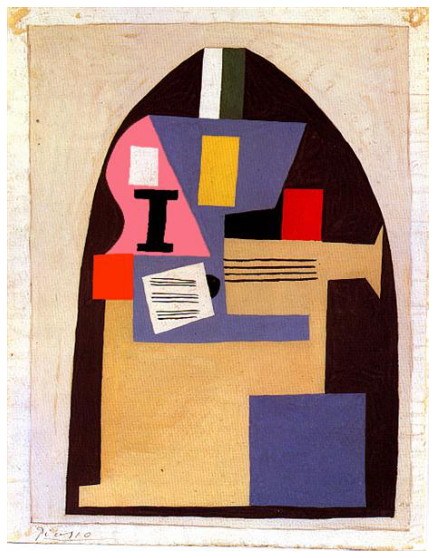

In [9]:
# set image to view
image_tag = "10_0542"

# open the image
demo_img  = load_artwork("".join(["full_image_", image_tag, ".jpg"]))

# view the image
show_artwork(demo_img)

## Generate a Palette Image
Here we reshape & resize image. This provides a standard amount of pixel for each artwork.

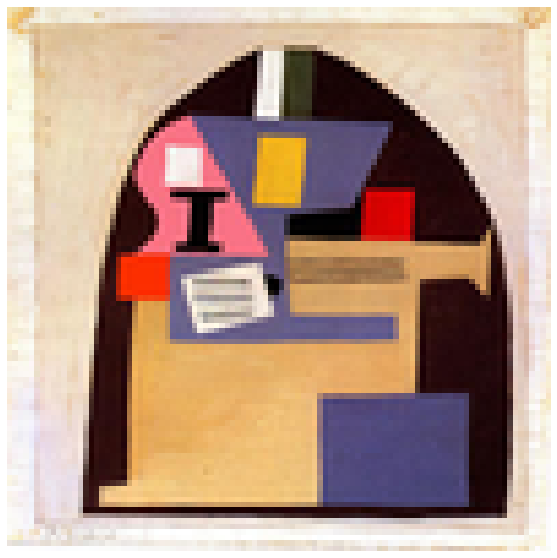

In [10]:
# resize the image
resized_image = demo_img.resize((RESIZE_IMAGE, RESIZE_IMAGE), Image.ANTIALIAS).convert('RGB')

# view colour squares
show_artwork(resized_image)

## Convert the Image to Palette Using KMeans

In [11]:
# convert image to a numpy array
img = np.array(resized_image)

# create matrix of pixels
X = img.reshape(-1, 3) # size (n, 3) where n is the number of pixels

# apply k-means
kmeans = KMeans(n_clusters = NUMBER_OF_IMAGE_PALETTE_COLOURS, random_state = 42)

# fit
kmeans.fit(X, y = None)

# get the array of centroids (the new color palette)
palette = kmeans.cluster_centers_

Review the __R, G, B__ values created.

In [12]:
# convert the palete to a dataframe
palette_df = pd.DataFrame(palette, columns =["r", "g", "b"])

# view the pallete
palette_df

,r,g,b
0,78.991292,71.525399,118.682148
1,223.409338,196.637351,167.479913
2,31.962151,7.288845,8.561753
3,247.584582,243.963597,237.643469
4,239.217544,192.028070,120.443860
5,159.844898,113.297959,79.102041
6,232.473232,212.233972,189.456048
7,227.275449,26.191617,6.005988
8,239.410000,176.610000,30.000000
9,246.714286,115.406250,133.803571


## Flatten the palette
Here we round the __R, G, B__ values down to _flatten_ them.

In [13]:
# simplify the values as integers and round down to the nearest 10
flattened_palette_df = palette_df.apply(lambda x: round(x/10) * 10).astype("int") 

# view the data
flattened_palette_df

,r,g,b
0,80,70,120
1,220,200,170
2,30,10,10
3,250,240,240
4,240,190,120
5,160,110,80
6,230,210,190
7,230,30,10
8,240,180,30
9,250,120,130


## Take a look at the Palette 
Here we see the 16 chosen palette colours.

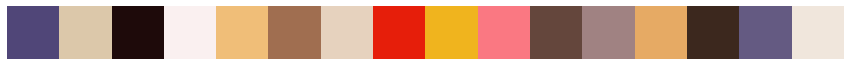

In [14]:
# show the palette image
show_artwork(np.array(flattened_palette_df[["r", "g", "b"]]).reshape((1,NUMBER_OF_IMAGE_PALETTE_COLOURS,3)))

## Place the Colours within the Palette into a standard order

In [15]:
# generate colour number
flattened_palette_df["colour"] = flattened_palette_df.apply(lambda row:  (row["r"] * 65536) +(row["g"] * 256) + row["b"] , axis=1 )

# view the data
flattened_palette_df

,r,g,b,colour
0,80,70,120,5260920
1,220,200,170,14469290
2,30,10,10,1968650
3,250,240,240,16445680
4,240,190,120,15777400
5,160,110,80,10514000
6,230,210,190,15127230
7,230,30,10,15080970
8,240,180,30,15774750
9,250,120,130,16414850


Above we order the colours by assigning each one with a unique colour value. This is generated by multiplying the __r__ value by __65536__, the __g__ value by __256__ and adding the __b__ value. Once this is done, the colourse are sorted by this number _ascending_. This gaurentees that a palette generated with the same colours will always have the colours in the same order. <br/>
__NOTE:__ the ordering is a numeric one. It may not mean that the colours are listed in a visually pleasing ordering.

In [16]:
# sort colour number
flattened_palette_sorted_df = flattened_palette_df.sort_values(by = ["colour"], ascending = True)

# view the data
flattened_palette_sorted_df

,r,g,b,colour
2,30,10,10,1968650
13,60,40,30,3942430
0,80,70,120,5260920
10,100,70,60,6571580
14,100,90,130,6576770
5,160,110,80,10514000
11,160,130,130,10519170
1,220,200,170,14469290
7,230,30,10,15080970
12,230,170,100,15116900


In [17]:
# 1d array of colour numbers
palette_colour_flattened_numbers = np.array(flattened_palette_sorted_df[["r", "g", "b"]]).reshape((1,NUMBER_OF_IMAGE_PALETTE_COLOURS,3))

## Take a look at the ordered Palette 
__NOTE:__ the colours may not be in the order a human would arrange them visually. But, instead they are in a numeric value order which is applied across all created Palettes.

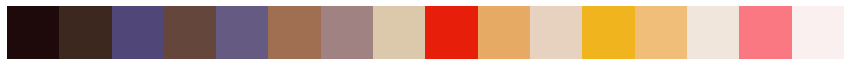

In [18]:
# show the palette image
show_artwork(palette_colour_flattened_numbers)

## View Example Palettes from Artists Artworks
Here we loop through the Artists and select the first three artworks from their collection. We then generate the palettes from these artworks and display them. This is intended to be used purely as a visualization of the process.

Agnes Martin


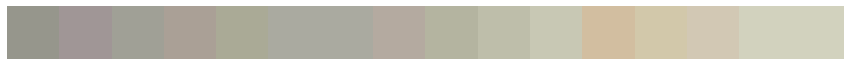

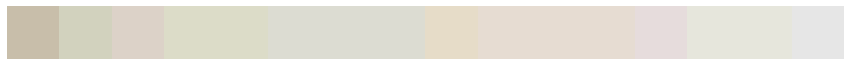

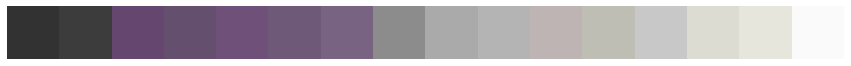

Berthe Morisot


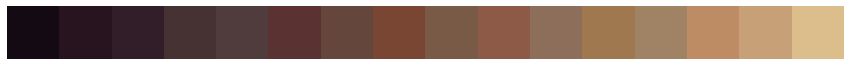

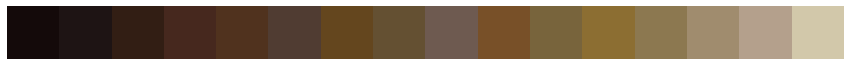

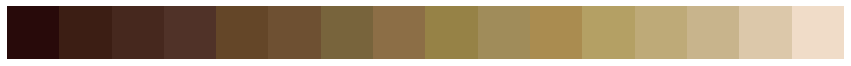

Edward Hicks


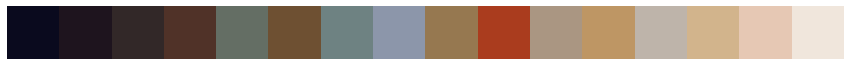

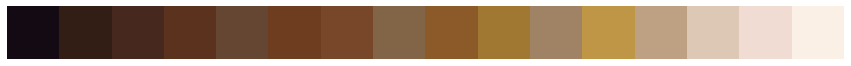

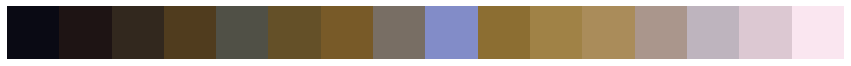

Francisco Goya


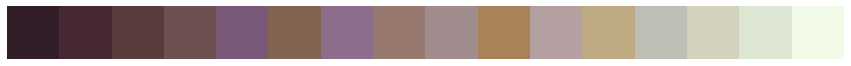

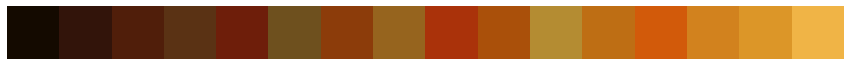

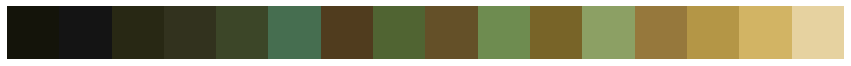

Henry Fuseli


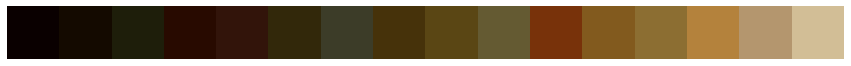

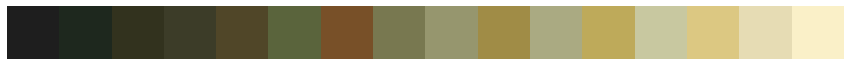

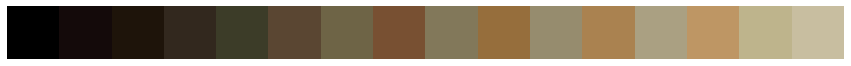

Jackson Pollock


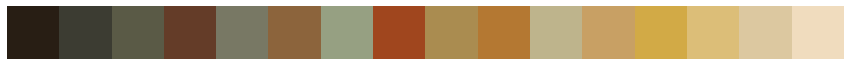

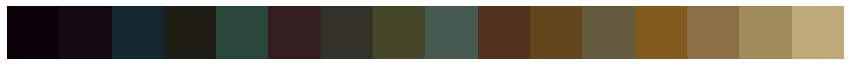

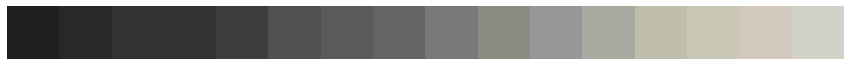

Karl Bodmer


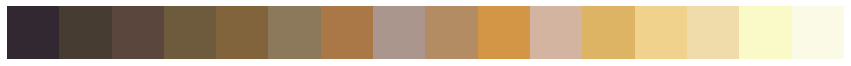

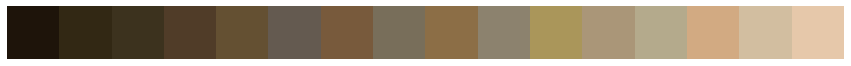

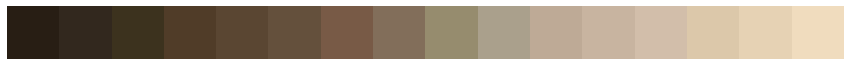

Katsushika Hokusai


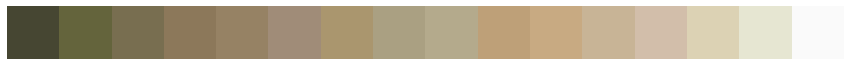

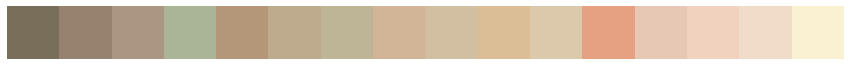

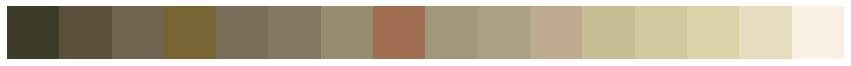

L. S. Lowry


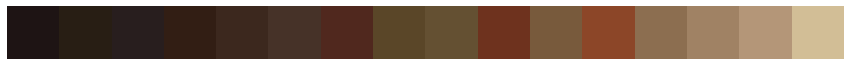

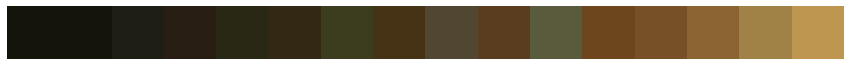

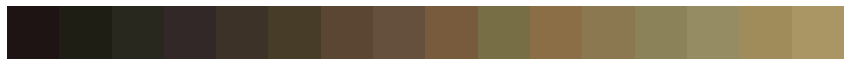

M.C. Escher


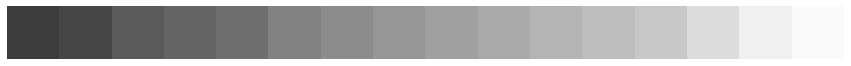

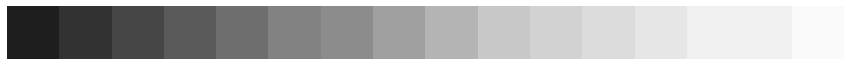

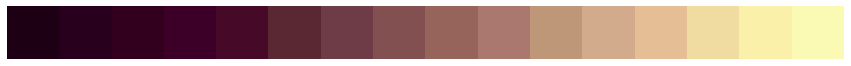

Pablo Picasso


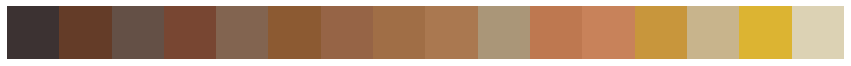

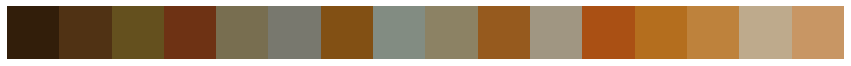

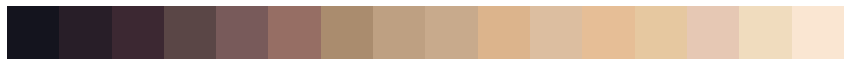

Piet Mondrian


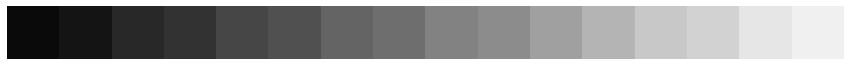

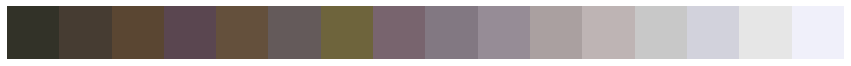

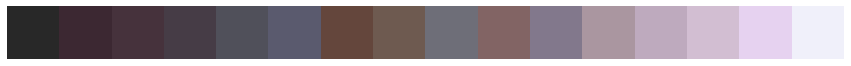

Roy Lichtenstein


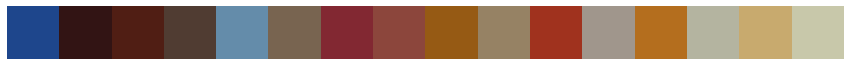

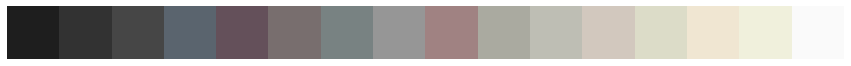

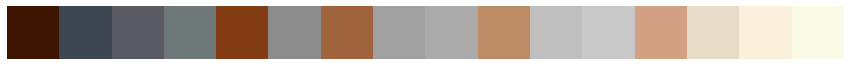

Tamara de Lempicka


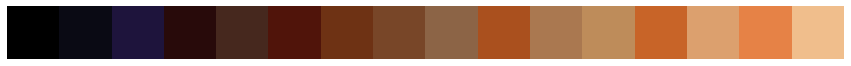

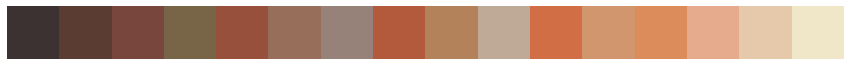

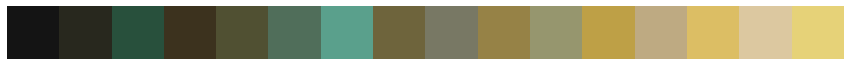

In [19]:
# define query to select the list of artists
query_string = "SELECT ID, NAME FROM ARTIST"

# execute the query
lookup = pd.read_sql_query(query_string, conn)

# loop through the artists
for artist_id in range(0,len(lookup)):
    
    # show the artists name
    print(lookup["name"][artist_id])
    
    # show the palette from the first 3 works of art
    for artwork_id in range(0,3):
        
        # load the image file
        img = load_artwork("".join(["full_image_","{:02d}_{:04d}".format(artist_id, artwork_id), ".jpg"]))
        
        #generate the palette
        pal = generate_palette(img)
        
        # show the pallete
        show_artwork(pal)

## Spliting the Datasets into __Train__, __Test__ & __Validation__ Subsets
Both _genre_ & _artist_ colour sets have __3306__ entries. But, the _style_ colour set has __3742__. This is because an artwork may have more than one sytle associated with it. To allow the _colour sets_ to be split into _train_, _test_ & _validation_ subsets the _image_tag_ must be used to decide the final set detination. Here we perfor a double _train_test_split_ to achieve a splt ratio of approx: __70%__, __20%__ & __10%__.
<br/>
Create a simple query against the RDBMS to return a list of all _IMAGE_TAGs_. <br/>__NOTE:__ The splits are kept consistence with the use of the <code>RANDOM_STATE</code> being set throughout the project to value: __42__.

In [20]:
# NOTE: select a list of unique image tags
query_string = """
SELECT IMAGE_TAG
FROM   ARTWORK_IMAGE
"""

# create the results dataframe
i_tags = pd.read_sql_query(query_string, conn)

# using the train test split we first extract our taining set which leaves a remainder
train_tags   , remainder_tags, _, _ = train_test_split(i_tags        , i_tags        , test_size = 0.3, random_state = RANDOM_STATE)

# now the reaminder is is split into a test and a validation set
validate_tags, test_tags     , _, _ = train_test_split(remainder_tags, remainder_tags, test_size = 0.7, random_state = RANDOM_STATE)

# create a list of image tags for each grouping
train_tags    = train_tags[   "image_tag"].to_numpy()
test_tags     = test_tags[    "image_tag"].to_numpy()
validate_tags = validate_tags["image_tag"].to_numpy()

## Build the __Genre__ Palette Set Arrays

Query the RDBMS to return a list of all __IMAGE_TAG__ values and the associated __GENRE__ catagories.

In [21]:
# define query
query_string = """
SELECT IMAGE_TAG,
       GENRE
FROM   GENRE         AS A,
       ARTWORK       AS B,
       ARTWORK_IMAGE AS C
WHERE  A.ID = B.GENRE_ID
AND    B.ID = C.ARTWORK_ID
"""
    
# execute query
genre_query_result = pd.read_sql_query(query_string, conn)

Here we loop through every every __IMAGE_TAG__ and identify if the palete colour data should be in the __TRAIN, TEST__ or __VALIDATE__ dataset. Once the correct destination has been identified. The colour data is added to a set of array and finally written to one of three compressed data file.

In [22]:
# define feature set arrays
palettes_tr  = []
palettes_te  = []
palettes_va  = []
genre_tr     = []
genre_te     = []
genre_va     = []
image_tag_tr = []
image_tag_te = []
image_tag_va = [] 

# loop through selection rows
for index, row in genre_query_result.iterrows():

    # open the image
    img  = Image.open("".join([image_file_path, "full_image_", row["image_tag"] ,".jpg"]))

    # get the palette colours
    palette_colours = generate_palette(img)

    # check in smallest dataset and then second 
    # smallest dataset for speed
    if row["image_tag"] in validate_tags:
        # append palettes
        palettes_va.append(palette_colours  )
        genre_va.append(    row["genre"]    )
        image_tag_va.append(row["image_tag"])
    elif row["image_tag"] in test_tags:
        # append palettes
        palettes_te.append(palette_colours  )
        genre_te.append(    row["genre"]    )
        image_tag_te.append(row["image_tag"])
    else:
        # append palettes
        palettes_tr.append(palette_colours  )
        genre_tr.append(    row["genre"]    )
        image_tag_tr.append(row["image_tag"])
    
 # write files
savez_compressed("".join([palette_sets,"genre_train_palettes"     ]), palettes_tr, genre_tr, image_tag_tr)
savez_compressed("".join([palette_sets,"genre_test_palettes"      ]), palettes_te, genre_te, image_tag_te)
savez_compressed("".join([palette_sets,"genre_validation_palettes"]), palettes_va, genre_va, image_tag_va)

## Build the __Style__ Palette Set Arrays

Query the RDBMS to return a list of all __IMAGE_TAG__ values and the associated __STYLE__ catagories.

In [23]:
# NOTE: we generate additonal records here becaus an artwork can be listed with more than one style
query_string = """
SELECT IMAGE_TAG,
       STYLE
FROM   STYLE         AS A,
       ARTWORK_STYLE AS B,
       ARTWORK_IMAGE AS C
WHERE   B.STYLE_ID  = A.ID   
AND    C.ARTWORK_ID = B.ARTWORK_ID
"""
    
style_query_result = pd.read_sql_query(query_string, conn)

Here we loop through every every __IMAGE_TAG__ and identify if the palete colour data should be in the __TRAIN, TEST__ or __VALIDATE__ dataset. Once the correct destination has been identified. The colour data is added to a set of array and finally written to one of three compressed data file.

In [24]:
# define feature set arrays
palettes_tr  = []
palettes_te  = []
palettes_va  = []
style_tr     = []
style_te     = []
style_va     = []
image_tag_tr = []
image_tag_te = []
image_tag_va = []

# loop through selection rows
for index, row in style_query_result.iterrows():

    # open the image
    img  = Image.open("".join([image_file_path, "full_image_", row["image_tag"] ,".jpg"]))

    # get the palette colours
    palette_colours = generate_palette(img)
    
    # check in smallest dataset and then second 
    # smallest dataset for speed
    if row["image_tag"] in validate_tags:
        # append palettes
        palettes_va.append(palette_colours  )
        style_va.append(    row["style"]    )
        image_tag_va.append(row["image_tag"])
    elif row["image_tag"] in test_tags:
        # append palettes
        palettes_te.append(palette_colours  )
        style_te.append(    row["style"]    )
        image_tag_te.append(row["image_tag"])
    else:
        # append palettes
        palettes_tr.append(palette_colours  )
        style_tr.append(    row["style"]    )
        image_tag_tr.append(row["image_tag"])
    
 # write files
savez_compressed("".join([palette_sets,"style_train_palettes"     ]), palettes_tr, style_tr, image_tag_tr)
savez_compressed("".join([palette_sets,"style_test_palettes"      ]), palettes_te, style_te, image_tag_te)
savez_compressed("".join([palette_sets,"style_validation_palettes"]), palettes_va, style_va, image_tag_va)

## Build the __Artist__ Palette Set Arrays

Query the RDBMS to return a list of all __IMAGE_TAG__ values and the associated __ARTIST__ name.

In [25]:
# NOTE: we generate additonal records here becaus an artwork can be listed with more than one style
query_string = """
SELECT IMAGE_TAG,
       NAME
FROM   ARTWORK       AS A,
       ARTIST        AS B,
       ARTWORK_IMAGE AS C
WHERE  A.ARTIST_ID = B.ID   
AND    A.ID        = C.ARTWORK_ID
"""
    
artist_query_result = pd.read_sql_query(query_string, conn)

Here we loop through every every __IMAGE_TAG__ and identify if the palete colour data should be in the __TRAIN, TEST__ or __VALIDATE__ dataset. Once the correct destination has been identified. The colour data is added to a set of array and finally written to one of three compressed data file.

In [26]:
# define feature set arrays
palettes_tr  = []
palettes_te  = []
palettes_va  = []
artist_tr    = []
artist_te    = []
artist_va    = []
image_tag_tr = []
image_tag_te = []
image_tag_va = []

# loop through selection rows
for index, row in artist_query_result.iterrows():

    # open the image
    img  = Image.open("".join([image_file_path, "full_image_", row["image_tag"] ,".jpg"]))

    # get the palette colours
    palette_colours = generate_palette(img)
    
    # check in smallest dataset and then second 
    # smallest dataset for speed
    if row["image_tag"] in validate_tags:
        # append palettes
        palettes_va.append(palette_colours  )
        artist_va.append(   row["name"     ])
        image_tag_va.append(row["image_tag"])
    elif row["image_tag"] in test_tags:
        # append palettes
        palettes_te.append(palette_colours  )
        artist_te.append(   row["name"     ])
        image_tag_te.append(row["image_tag"])
    else:
        # append palettes
        palettes_tr.append(palette_colours  )
        artist_tr.append(   row["name"     ])
        image_tag_tr.append(row["image_tag"])
    
 # write files
savez_compressed("".join([palette_sets,"artist_train_palettes"     ]), palettes_tr, artist_tr, image_tag_tr)
savez_compressed("".join([palette_sets,"artist_test_palettes"      ]), palettes_te, artist_te, image_tag_te)
savez_compressed("".join([palette_sets,"artist_validation_palettes"]), palettes_va, artist_va, image_tag_va)